
###  Exercise set 3: Sampling and Kernel Methods 
#### Solution by Loreen Ruhm and Philipp Hummel

E1. Given is a random variable z that is uniformly distributed over (0,1). We want to find a transformation $y = f(z)$ such that $y$ has a Cauchy distribution:

\begin{equation}
p(y) = \frac{1}{\pi}\frac{1}{1 + y^2}
\end{equation}

Herefore, we first start with the cumulative distribution function (CDF):

\begin{equation}
F(Y) = \int_{- \infty}^{Y} f(y) dy
\end{equation}

For Cauchy, this frunction is given by:

\begin{equation}
F(y) = \frac{1}{2} + \frac{1}{\pi}\arctan(y) 
\end{equation}

As we know, $F(y)$ has values between 0 and 1. So to find the transformation $f(z)$, we can set $F(y)$ equal to $F(z) = z$ (as $z$ uniformly distributed on $[0, 1]$):

\begin{equation}
z = \frac{1}{2} + \frac{1}{\pi}\arctan(y) 
\end{equation}

By solving this equation for $y$, we find our wanted transformation:

\begin{equation}
y = \tan(\pi \cdot (z - \frac{1}{2}))
\end{equation}

#### E2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy

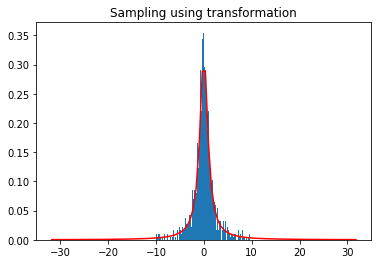

In [4]:
# Sampling from Cauchy distribution using the transformation
def cauchyTransformation(z):
    y = np.tan(np.pi * (z - 0.5))
    return y

z = np.random.uniform(0.0, 1.0, 1000)
y = cauchyTransformation(z)

plt.hist(y, bins=100, range=(-10,10), normed=True)  # arguments are passed to np.histogram
plt.title("Sampling using transformation")
x = np.linspace(cauchy.ppf(0.01),cauchy.ppf(0.99), 100)
plt.plot(x, cauchy.pdf(x),'r-', lw=1.5, alpha=1)
plt.show()

#### E3

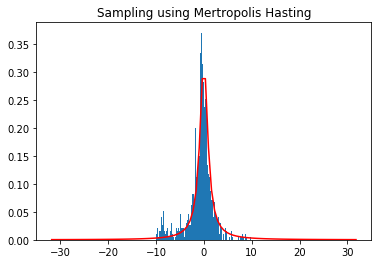

In [6]:
# Sampling from Cauchy distribution using MCMC
def cauchyDist (y):
    return 1/np.pi * 1/(1 + y**2)


L = 1000

samples = np.zeros((L,1))

for i in range(1,L):
        z = np.random.normal(samples[i-1], 1.0)
        a = cauchyDist(z)/cauchyDist(samples[i-1])
        if (a >= 1):
            samples[i] = z
        else:
            u = np.random.uniform(0.0,1.0,1)
            if u < a:
                samples[i] = z
            else:
                samples[i] = samples[i-1]
        
        
plt.hist(samples, bins=100, range=(-10,10), normed=True)  # arguments are passed to np.histogram
plt.title("Sampling using Mertropolis Hasting")
x = np.linspace(cauchy.ppf(0.01),cauchy.ppf(0.99), 100)
plt.plot(x, cauchy.pdf(x),'r-', lw=1.5, alpha=1)
plt.show()      

As we see Metropolis–Hastings algorithm also fits well to the Cauchy distribution.

### 2 Kernels 

#### E4. 
We assume the linear basis function model with $\phi_n(x) = \exp(-|x-x_n|^2/(2 \sigma_{\phi}^2))$. First, we want to compute the maximum likelihood solution for approximating the data points $(x_n, t_n)$. Hereby we assume that the data is generated by the model prediction plus Gaussian noise with density $p(\epsilon) = N(\epsilon|0, \beta^{-1})$. The likelihood is given by:

\begin{equation}
p(t|x,w,\beta) = \sum_n N(t_n | w^T \phi (x_n), \beta^{-1}) 
\end{equation}

To maximize this function with respect to there weights, it is easier to look at the $\ln$ of this function. From the lecture, we know that this is given by:

\begin{equation}
\ln p(t|w,\beta) = \frac{N}{2} \ln \beta - \frac{N}{2} \ln(2 \pi) - \frac{\beta}{2} \sum_n (t_n - w^T \phi(x_n))^2
\end{equation}

Now we take the derivative:

\begin{equation}
\nabla_w \ln p(t,w,\beta) = \beta \sum_n (t_n - w^T \phi(x_n)) \phi(x_n)^T = 0
\end{equation}

Rearranging leads to:

\begin{equation}
w_{ML} = (\Phi^T \Phi)^{-1} \Phi^T t, 
\end{equation}
where $\Phi$ is $N \times M$ matrix with colunms that are different features(e.g. $M$ in our case equal to $20$). 

#### E5. 
Now we want to compute the corresponding Baysian regression solution assuming a prior $p(w) = N(w|0,\alpha^{-1} I)$. For this approach, we look at the posterior:

\begin{equation}
p(w|x,t,\alpha, \beta) \propto p(t|x,w,\beta) p(w|0,\alpha^{-1} I)
\end{equation}

Here, again one can take the $\ln$. The solution can be found by minimizing (irrelevant terms neglected):

\begin{equation}
- \ln p(w|x,t,\alpha, \beta) \propto \frac{\beta}{2} \sum_n (w^T \phi(x_n) - t_n)^2 + \frac{\alpha}{2} w^T w
\end{equation}

The derivative with respect to the weights is given by:

\begin{equation}
0 = \beta \sum_n (t_n - w^T \phi(x_n)) \phi(x_n)^T - \alpha w^T
\end{equation}

So the solution is:

\begin{equation}
w =  (\Phi^T \Phi + \frac{\alpha}{\beta} I)^{-1}\Phi^T t
\end{equation}

It is probably better to use this solution because the additional term acts as a regularization term. This prevents high values of $w$.

E6. Next we want to write a program that implements our solutions from above. Herefore, a data is given. We use $N = 19$ points (there are only 19) and assume a precision of $\beta = 50$. We want to compute the solution for different kernels:

a) $\sigma_\phi = 1$

b) $\sigma_\phi = 10$

c) $\sigma_\phi = 0.1$

For the Bayesian regression, we try two alphas: $\alpha = 1$ and $\alpha = 10^{-8}$.

The solutions are plotted below the program and errors of the test and the training set are given. We start with the maximum likelihood solution. Before we start, we read the data.

In [8]:
x = np.loadtxt('Traindatax')
y = np.loadtxt('Traindatay')
x_test = np.loadtxt('Testdatax')
y_test = np.loadtxt('Testdatay')

In [9]:
# here we define our transformation to gererate features. 
def kernel(x, x_0, scale):
    return np.exp(-(x-x_0)**2/(2*scale ** 2))

In [10]:
def dm(x, x_train, kernel_scale=1):
    dm = np.ones((len(x),len(x_train)+1))

    for i in range(len(x)):
        dm[i,1:] = kernel(x_train, x[i], scale=kernel_scale)
    return dm

In [11]:
def train_ml_plot(x, y, x_test, y_test, scale=1):
    dm_1 = dm(x,x,scale)
    w = np.linalg.pinv(dm_1)@y
    y_hat_train = dm_1@w.T
    y_hat_test = dm(x_test, x, kernel_scale=scale)@w.T
    train_e = np.sum((y_hat_train-y)**2)
    test_e = np.sum((y_hat_test-y_test)**2)
    print('train error: ', train_e)
    print('test error: ', test_e)
    
    x_plot = np.linspace(0,6.5,100)
    y_plot = dm(x_plot,x,kernel_scale=scale)@w.T
    plt.plot(x_plot, y_plot, label ='prediction')
    plt.scatter(x, y, label='train')
    plt.scatter(x_test, y_test, label='test')
    plt.ylim((-2,2))
    plt.legend()

Next we implement our solutions using maximum likelihood (ML). The used $sigma$ is given as parameter to the function. I plotted the results for the test set and printed out the error on the training and test set. 

train error:  3.63543975085e-08
test error:  123.543540762


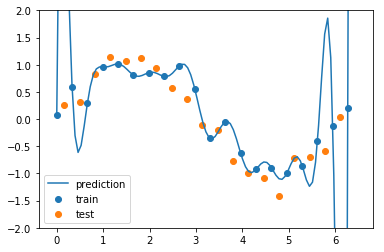

In [12]:
train_ml_plot(x,y,x_test,y_test,scale=1)

train error:  3.23805157102e-29
test error:  4.36835918947


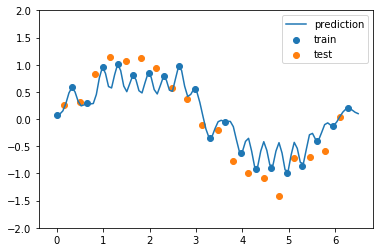

In [13]:
train_ml_plot(x,y,x_test,y_test,scale=0.1)

train error:  0.598167674279
test error:  0.948497265715


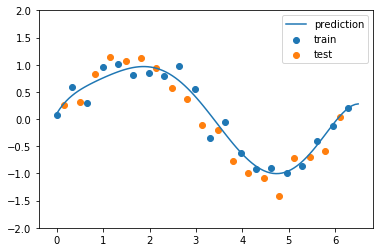

In [14]:
train_ml_plot(x,y,x_test,y_test,scale=10)

The kernel scale is a locality parameter. The bigger the scale the more smooth the estimated function will be.

Next we want to take a look at the Bayesian regression (BR) solution. Here, we also look at different $\sigma$. In addition, the solutions are also plotted for different $\alpha$.

Bayesian solution: 

In [25]:
def train_bayesian_plot(x, y, x_test, y_test, a=1, b=50, kernel_scale=1):
    dm1 = dm(x,x,kernel_scale)
    n_w = len(x)+1
    S = np.linalg.inv(a*np.eye(n_w) + b*dm1.T@dm1)
    m = b*S@dm1.T@y

    x_plot = np.linspace(0,6.5,300)
    dm_plot = dm(x_plot,x,kernel_scale=kernel_scale)
    y_plot = dm_plot@m.T
    y_std = np.sqrt(np.diagonal(1/b + dm_plot@S@dm_plot.T))
    
    y_hat_train = dm1@m.T
    y_hat_test = dm(x_test,x,kernel_scale=kernel_scale)@m.T
    train_error = np.sum((y_hat_train-y)**2)
    test_error = np.sum((y_hat_test-y_test)**2)
    print('train error: ', train_error)
    print('test error: ', test_error)

    plt.plot(x_plot, y_plot, label ='posterior predictive mean')
    plt.scatter(x, y, label='train')
    plt.scatter(x_test, y_test, label='test')
    plt.fill_between(x_plot, y_plot-2*y_std, y_plot+2*y_std ,alpha=0.2, label='2*std')
    plt.ylim((-2,2))
    plt.legend()

train error:  0.614673565333
test error:  0.898904905785


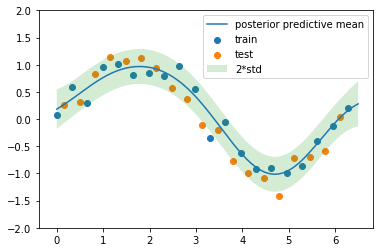

In [26]:
train_bayesian_plot(x, y, x_test, y_test, a=1,b=50,kernel_scale=1)

train error:  0.322299738821
test error:  1.21430415158


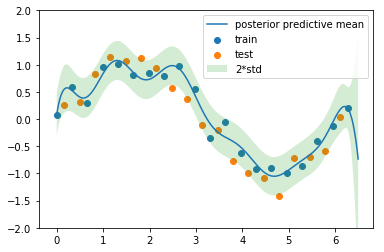

In [27]:
train_bayesian_plot(x, y, x_test, y_test, a=1e-8,b=50,kernel_scale=1)

train error:  5.37430401195
test error:  6.03403677751


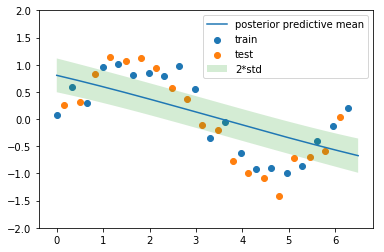

In [28]:
train_bayesian_plot(x, y, x_test, y_test, a=1,b=50,kernel_scale=10)

train error:  0.823479027727
test error:  1.01468251705


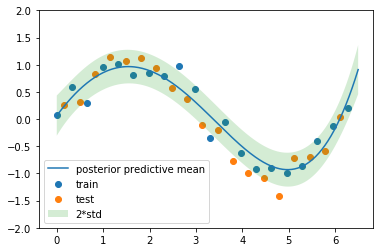

In [29]:
train_bayesian_plot(x, y, x_test, y_test, a=1e-8,b=50,kernel_scale=10)

train error:  0.00359511312523
test error:  4.47555856051


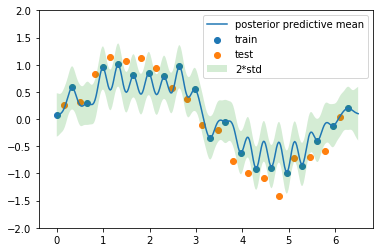

In [30]:
train_bayesian_plot(x, y, x_test, y_test, a=1,b=50,kernel_scale=0.1)

train error:  2.64919110142e-13
test error:  4.3683593944


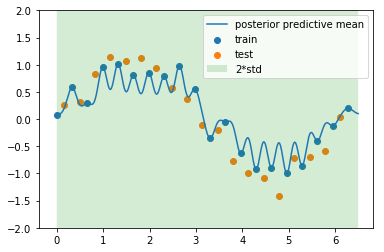

In [31]:
train_bayesian_plot(x, y, x_test, y_test, a=1e-8,b=50,kernel_scale=0.1)

We see that the regularization in BR improves the results, especially for higher values of $\sigma$. As already mentioned this is because it acts as a regularization and keeps values of $w$ low. For small variations $\sigma$ the impact is smaller. This also makes sense as the width of the basis functions is smaller.

** 3 Kernel engineering **

E7. First we want to show that $c k_1(x,x')$ with $c > 0$ is a valid kernel function assuming that $k_1(x,x')$ is a valid kernel function. Therefore (see hint), we have to show that the new kernel can be written as a scalar product of feature vectors. First, we use that $k_1$ is a valid kernel and therefore can be written as a scalar product of two feature vecotrs $\phi$:

\begin{equation}
k_1(x,x') = \phi(x)^T \phi(x')
\end{equation}

Therefore, $c k_1$ can be rewritten as:

\begin{equation}
c k_1(x,x') = c \phi(x)^T \phi(x')
\end{equation}

As $c$ is a positive scalar, we can write:

\begin{equation}
c k_1(x,x') = \sqrt(c) \phi(x)^T \phi(x') \sqrt(c)
\end{equation}

With $\Phi(x) = \sqrt(c) \phi(x)$, we see that $c k_1$ can be also written as a scalar product of feature vectors:

\begin{equation}
c k_1(x,x') = \Phi(x)^T \Phi(x')
\end{equation}

And therefore, $c k_1(x,x')$ is also a valid kernel.

Next, we repeat that proof for $f(x) k_1(x,x') f(x')$. When we again write $k_1$ as a scalar product, we get:

\begin{equation}
f(x) k_1(x,x') f(x') = f(x) \phi(x)^T \phi(x') f(x')
\end{equation}

As $f$ is a scalar function, we can write:

\begin{equation}
f(x) k_1(x,x') f(x') = (f(x) \phi(x))^T \phi(x') f(x')
\end{equation}

Therefore, the feature function for $f(x) k_1(x,x') f(x')$ is:

\begin{equation}
\Phi(x) = f(x) \phi(x)
\end{equation}

E8. Now we want to show that $k_1(x,x') k_2(x,x')$ is a valid kernel if $k_1$ and $k_2$ are valid kernels. We again use the scalar product representation of $k_1$ and $k_2$

\begin{equation}
k_1(x,x') k_2(x,x') = \phi_1(x)^T \phi_1(x') \phi_2(x)^T \phi_2(x')
\end{equation}

Let us write the scalar product as sum of products of coordinates: 

\begin{equation}
\sum_{i=1}^{N} \phi_1(x)_i \phi_1(x')_i \sum_{j=1}^{M} \phi_2(x)_j \phi_2(x')_j
\end{equation}
We could we write this product of sums as one sum 
\begin{equation}
k_1(x,x') k_2(x,x') = \sum_{k=1}^{NM} (\phi_1(x)\phi_2(x))_k (\phi_1(x') \phi_2(x'))_k,
\end{equation}
where $k$ is indexing of countable set $\{1 ... N\}\times \{1 ... M\}.$


So $k_1(x,x') k_2(x,x')$ can be written as scalar product and is also a valid kernel.

E9. $h(k_1(x,x'))$ can be written as:

\begin{equation}
h(k_1(x,x')) = \sum_i a_i k_1(x,x')^i 
\end{equation}

We assumed $a_i > 0$ for all $i$ and we can easily conclude from E8. that products of valid kernel function are valid kernel function. So using the previous exercises, we know already that each single summand in the sum above is a valid kernel function. So we only have to show that the sum of valid kernel functions is a valid kernel function:

\begin{equation}
k_1(x,x') + k_2(x,x') = \phi_1(x)^T \phi_1(x) + \phi_2(x)^T \phi_2(x)
\end{equation}

We easily see that, the feature vector here is given by:

\begin{equation}
\Phi(x) = \begin{pmatrix}
\phi_1(x) \\
\phi_2(x)
\end{pmatrix}
\end{equation}

Therefore, sums of valid kernels are valid kernels and because of that and E7,E8 

$h(k_1(x,x'))$ is a valid kernel.

E10.Next we want to show that $\exp(k_1(x,x'))$ is a valid kernel. Therefore, we look at the series expansion of the e-function:

\begin{equation}
exp(x) = \sum_{n = 0}^{\infty} \frac{x^n}{n!}
\end{equation}

As $n!$ is always higher than $0$, this expansion fullfils the requirements of h(x) from E9.. Therefore, we can directly conclude from E9., that $exp(k_1(x,x')) is a valid kernel function.